# ACS2 in Multiplexer

In [1]:
%matplotlib inline

# General
from __future__ import unicode_literals

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Logger
import logging
logging.basicConfig(level=logging.WARN)

# ALCS + custom environments
import sys
sys.path.append('/Users/khozzy/Projects/pyalcs')
sys.path.append("/Users/khozzy/Projects/openai-envs")

# Enable automatic module reload
%load_ext autoreload
%autoreload 2

# Load PyALCS module
from alcs import ACS2, ACS2Configuration

# Load environments
import gym
import gym_multiplexer

## Multiplexer

In [2]:
mp = gym.make('boolean-multiplexer-6bit-v0')
situation = mp.reset()
mp.render()

'0010110'

In [3]:
state, reward, done, _ = mp.step(0)

print("New state: {}, reward: {}, is done: {}".format(state, reward, done))

New state: 0010110, reward: 0, is done: True


In [4]:
mp.render()

'0010110'

### Evaluation
Calculate knowledge - check if any of the reliable classifiers gives correct answer.

In [5]:
from gym_multiplexer.utils import get_correct_answer

def evaluate_performance(env, population, ctrl_bits):
    p1 = env.render()  # state after executing action
    p0 = p1[:-1] + '0'  # initial state
    true_action = get_correct_answer(p0, ctrl_bits)
    
    # get all classifiers matching initial state
    matching_cls = {c for c in population if c.condition.does_match(p0)}
    best_cl = max(matching_cls, key=lambda cl: cl.q)
        
    return {'was_correct': best_cl.predicts_successfully(p0, true_action, p1)}

## Go agent, go...
Perform experiment for a couple of explore/exploit trials.

In [6]:
cfg = ACS2Configuration(
    mp.env.observation_space.n,
    2,
    performance_fcn=evaluate_performance,
    performance_fcn_params={'ctrl_bits': 2},
    do_ga=True)

agent = ACS2(cfg)
population, metrics = agent.explore_exploit(mp, 50000)

In [7]:
print("Population size: {}".format(metrics[-1]['agent']['population']))
print("Reliable size: {}".format(metrics[-1]['agent']['reliable']))
print(metrics[-1])

Population size: 79
Reliable size: 25
{'agent': {'population': 79, 'numerosity': 311, 'reliable': 25, 'fitness': 384.2019607334401, 'trial': 49999, 'steps': 1, 'total_steps': 50000}, 'environment': None, 'performance': {'was_correct': True}}


In [8]:
reliable_classifiers = [c for c in population if c.is_reliable()]
reliable_classifiers = sorted(reliable_classifiers, key=lambda cl: -cl.q)

# Print top 20 classifiers
for cl in reliable_classifiers[:20]:
    print(f"{cl}, q: {cl.q:.2f}, exp: {cl.exp:.2f}")

10##1##-0-####### @ 0x108e04668, q: 1.00, exp: 934.00
10##0##-1-####### @ 0x108e04e48, q: 1.00, exp: 841.00
001####-0-####### @ 0x108e96b70, q: 1.00, exp: 892.00
10##0##-0-######1 @ 0x108e4f5f8, q: 1.00, exp: 2168.00
11###0#-1-####### @ 0x105489fd0, q: 1.00, exp: 803.00
000####-1-####### @ 0x108e968d0, q: 1.00, exp: 827.00
11###1#-0-####### @ 0x108e4fb00, q: 1.00, exp: 842.00
01#1###-0-####### @ 0x108edc550, q: 1.00, exp: 896.00
01#0###-0-######1 @ 0x108edc3c8, q: 1.00, exp: 2287.00
11###0#-0-######1 @ 0x108edcc18, q: 1.00, exp: 2280.00
000####-0-######1 @ 0x108e04a58, q: 1.00, exp: 2288.00
01#0###-1-####### @ 0x108edc400, q: 1.00, exp: 827.00
11###1#-1-######1 @ 0x108e96b38, q: 1.00, exp: 2172.00
001####-1-######1 @ 0x108e96438, q: 1.00, exp: 2179.00
01#1###-1-######1 @ 0x108edce10, q: 1.00, exp: 2159.00
10##1##-1-######1 @ 0x108edc2e8, q: 1.00, exp: 2012.00
1###00#-0-######1 @ 0x108edcbe0, q: 1.00, exp: 196.00
#00#0##-0-######1 @ 0x108edc978, q: 1.00, exp: 112.00
0#11###-1-######1 @ 

In [9]:
def parse_metrics_to_df(metrics):
    def extract_details(row):
        row['trial'] = row['agent']['trial']
        row['numerosity'] = row['agent']['numerosity']
        row['reliable'] = row['agent']['reliable']
        row['was_correct'] = row['performance']['was_correct']
        return row
    
    df = pd.DataFrame(metrics)
    df = df.apply(extract_details, axis=1)
    df.drop(['agent', 'environment', 'performance'], axis=1, inplace=True)
    df.set_index('trial', inplace=True)
    
    return df

df = parse_metrics_to_df(metrics)
df.head()

,numerosity,reliable,was_correct
trial,,,
0,1,0,True
1,1,0,True
2,2,0,False
3,2,0,False
4,3,0,False


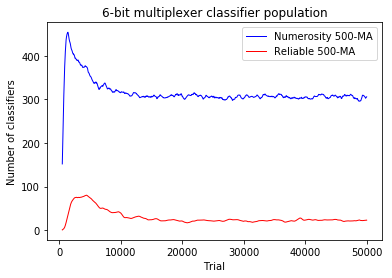

In [25]:
window=500

df['numerosity'].rolling(window=window).mean().plot(color='b', linewidth=1.0, label=f'Numerosity {window}-MA')
df['reliable'].rolling(window=window).mean().plot(color='r', linewidth=1.0, label=f'Reliable {window}-MA')
plt.ylabel('Number of classifiers')
plt.xlabel('Trial')
plt.title('6-bit multiplexer classifier population')
plt.legend()
#plt.show()

plt.savefig('6bit_mp_classifiers.eps', format='eps', dpi=100)

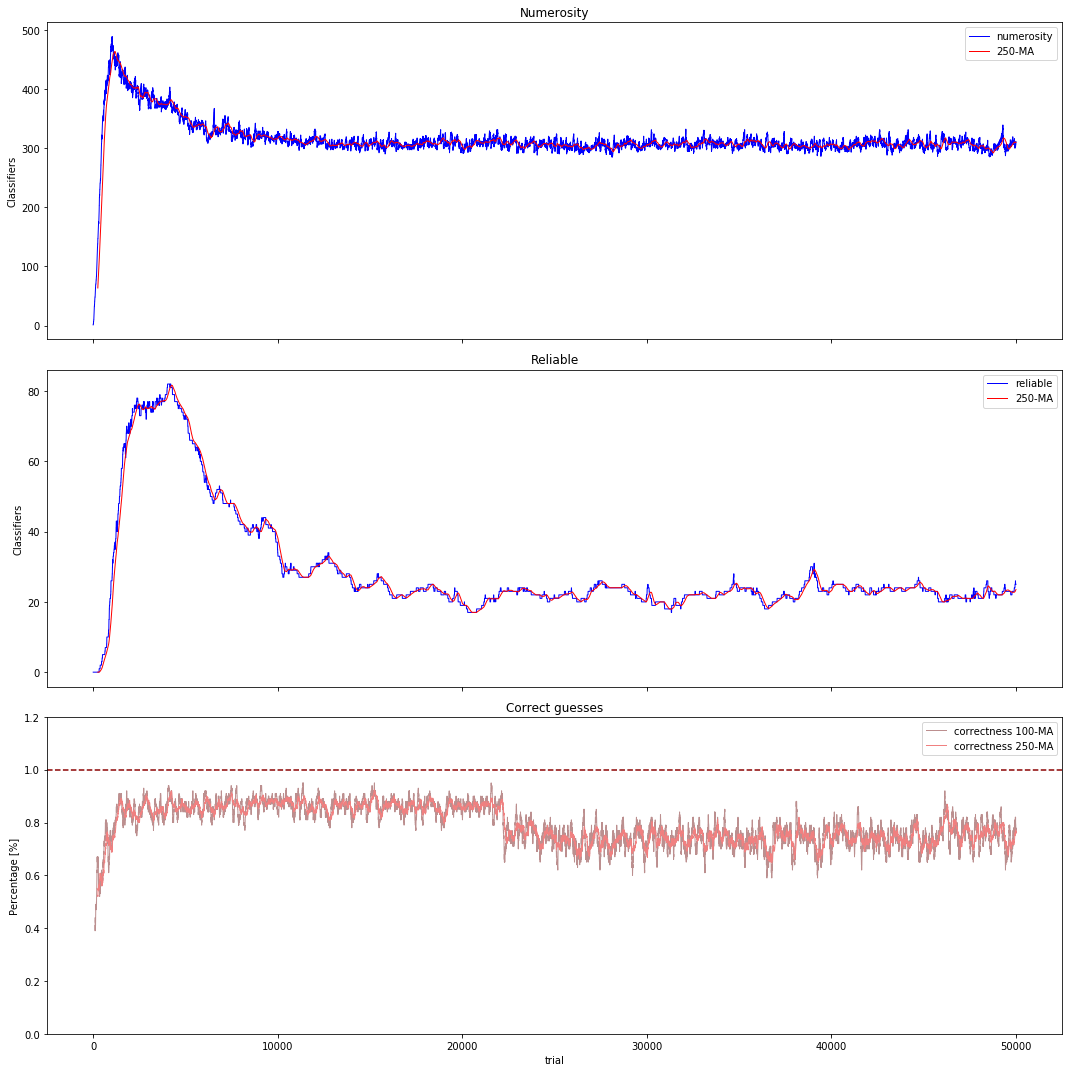

In [10]:
f, (ax1, ax2, ax3) = plt.subplots(3, sharex=True, figsize=(15,15))

# Numerosity
df['numerosity'].plot(ax=ax1, color='blue', linewidth=1.0, label='numerosity')
df['numerosity'].rolling(window=250).mean().plot(ax=ax1, color='r', linewidth=1.0, label='250-MA')
ax1.set_title('Numerosity')
ax1.set_ylabel('Classifiers')
ax1.legend()

# Reliable
df['reliable'].plot(ax=ax2, color='b', linewidth=1.0, label='reliable')
df['reliable'].rolling(window=250).mean().plot(ax=ax2, color='r', linewidth=1.0, label='250-MA')
ax2.set_title('Reliable')
ax2.set_ylabel('Classifiers')
ax2.legend()

# Obtained performance
df['was_correct'].rolling(window=100).mean().plot(ax=ax3, linewidth=1.0, color='rosybrown', label='correctness 100-MA')
df['was_correct'].rolling(window=250).mean().plot(ax=ax3, linewidth=1.0, color='lightcoral', label='correctness 250-MA')
ax3.axhline(y=1.0, c='darkred', linewidth=1.5, linestyle='dashed')
ax3.set_title('Correct guesses')
ax3.set_ylabel('Percentage [%]')
ax3.set_ylim([0, 1.2])
ax3.legend()

plt.tight_layout()
plt.show()